# Retinal Disease Recognition and Localisation through Convolutional Neural Networks

The main objective of this notebook is to construct a classifier capable of distinguishing between different retinal diseases such as drusen, choroidal neovascularisation and diabetic macular edema.   

The models obtained will be compared with the main architectures used in the state of the art.
Finally, the Gradient-Weighted Class Activation Mapping (GradCAM) algorithm will be used to highlight the portions of the image that are most significant for classification purposes, in order to assess the network's correct learning of clinical patterns.

# 1. Background
In this section, the pathologies featured in the classification will be discussed in more detail from a clinical point of view.  

## 1.1 - Drusen
Drusen are yellow or white deposits, consisting mainly of protein-lipid material, that form under the retina, exactly between the retinal pigment epithelium and Bruch's membrane.  
There are at least two types of drusen:
- Rigid drusen possess small dimensions, are arranged far apart from each other and are generally not related to any ocular problem.

- Soft drusen, on the other hand, are large deposits (larger than rigid drusen), often arranged next to each other, with poorly defined borders and usually found in people with dry age-related macular degeneration.

Typically, drusen begin to make their first appearance around the age of 40.
In people aged 60 or older, they are very common occurrences, so they can be considered typical of old age.
## 1.2 - Choroidal neurovascularisation (CNV)
Choroidal neovascularization (CNV) is part of the spectrum of exudative age-related macular degeneration (AMD) that consists of an abnormal growth of vessels from the choroidal vasculature to the neurosensory retina through the Bruch's membrane.  
CNV can also develop in a number of other conditions such as myopic degeneration, chronic central serous chorioretinopathy, macular telangiectasia type 2, various white dot syndromes and other uveitic processes, and some choroidal tumors. Leakage of retinal edema and hemorrhage from CNV threatens visual acuity.  
Histologically, neovascular membranes are classified into:

- **Type 1** ("occult"), when the neovascular membrane is located below the RPE. Type 1 CNV demonstrates occult leakage on fluorescein angiography. Polypoidal choroidal vasculoplathy (PCV) is a subtype of Type 1 CNV that is characterized by the presence of polyp-like aneurysmal dilations of the branching vascular network.

- **Type 2** ("classic"), passes through the RPE and is located above the RPE in the subretinal space. This is related to the angiographic classification of a classic CNV.

- **Type 3** is defined as Retinal Angiomatous Proliferation (RAP), which corresponds to neovascularization that develops within the neurosensory retina an progresses posteriorly into the subretinal space.

## 1.3 - Diabetic macular edema (DME)
DME is an eye condition which can occur in people living with diabetes – both type 1 and type 2. Consistently high blood sugar due to poor glucose control over time can damage small blood vessels in the body, including the eye. Diabetic retinopathy is a disease that damages the blood vessels in the retina, resulting in vision impairment. Left untreated, fluid can leak into the center of the macula, called the fovea, the part of the eye where sharp, straight-ahead vision occurs. The fluid makes the macula swell, blurring vision. This condition is called DME. It can occur at any stage of diabetic retinopathy, although it is more likely to occur as the disease progresses.  

People who have diabetes are at risk of developing DME over time. A person with diabetes should have their vision checked yearly, or as directed by their eye doctor.  
Vision changes due to DME are:

- Blurred vision

- Double vision

- Sudden increase in eye floaters

<center> <img src="notebook_images/fSTeZMd.png">  </center>
<center> Figure 1. Representative Optical Coherence Tomography Images. [Kermany et. al. 2018] </center>
<center> (Far left) choroidal neovascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic macular edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema. </center>

# 2. Experimental Analysis

## 2.1 Import main dependencies and define GradCAM class

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2

from keras import models
from keras import layers
from keras.metrics import Precision, Recall, AUC
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19, EfficientNetB0, InceptionV3, Xception

from tensorflow.keras.utils import image_dataset_from_directory as get_dataset
from tensorflow.keras.preprocessing import image

from tqdm import tqdm

In [2]:
from keras.models import Model

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

## 2.2 Data Exploration and Visualization

In [3]:
dataset_path = "/kaggle/input/kermany2018/OCT2017 /"

train_path = os.path.join(dataset_path, 'train/')
val_path = os.path.join(dataset_path, 'val/')
test_path = os.path.join(dataset_path, 'test/')

In [4]:
iSize = 100
imgSize = (iSize, iSize)
color_mode = 'rgb'
batch_size = 128
l_rate = 3e-4

In [5]:
print('\n[ TRAIN DATA ]')
train_data = get_dataset(
    train_path,
    labels='inferred',
    label_mode='int',
    image_size=imgSize,
    color_mode=color_mode,
    batch_size=batch_size,
    shuffle=True,
    seed=0)

print('\n[ VALIDATION DATA ]')
val_data = get_dataset(
    val_path,
    labels='inferred',
    label_mode='int',
    image_size=imgSize,
    color_mode=color_mode,
    batch_size=batch_size,
    shuffle=True,
    seed=0)

print('\n[ TEST DATA ]')
test_data = get_dataset(
    test_path,
    labels='inferred',
    label_mode='int',
    image_size=imgSize,
    color_mode=color_mode,
    batch_size=batch_size,
    shuffle=True,
    seed=0)


[ TRAIN DATA ]
Found 83484 files belonging to 4 classes.

[ VALIDATION DATA ]
Found 32 files belonging to 4 classes.

[ TEST DATA ]
Found 968 files belonging to 4 classes.


In [6]:
train_labels = np.concatenate([label for _, label in tqdm(train_data)], axis=0)
train_values = pd.value_counts(train_labels)
train_values = train_values.sort_index()

print(train_values)

100%|██████████| 653/653 [06:22<00:00,  1.71it/s]


0    37205
1    11348
2     8616
3    26315
dtype: int64


In [7]:
val_labels = np.concatenate([label for _, label in tqdm(val_data)], axis=0)
val_values = pd.value_counts(val_labels)
val_values = val_values.sort_index()

print(val_values)

100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

0    8
1    8
2    8
3    8
dtype: int64


In [8]:
test_labels = np.concatenate([label for _, label in tqdm(test_data)], axis=0)
test_values = pd.value_counts(test_labels)
test_values = test_values.sort_index()

print(test_values)

100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

0    242
1    242
2    242
3    242
dtype: int64


In [9]:
classes = train_data.class_names

for index, name in enumerate(classes):
    print(f"{index} = {name}", end=' ||| ')

0 = CNV ||| 1 = DME ||| 2 = DRUSEN ||| 3 = NORMAL ||| 

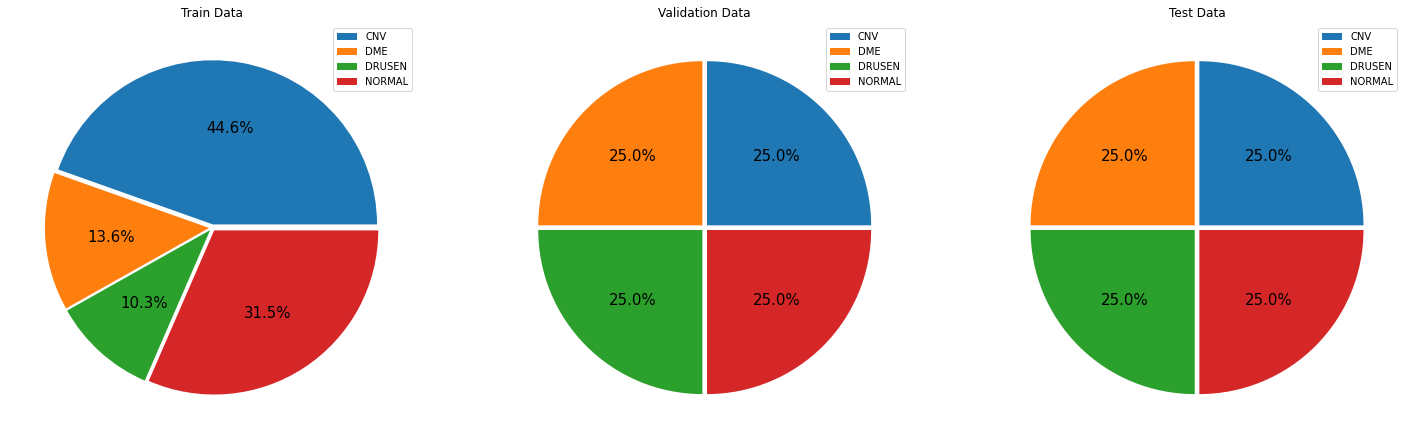

In [10]:
plt.figure(figsize=(25, 11))

plt.subplot(1,3,1)
plt.pie(train_values,autopct='%1.1f%%', explode = [0.02,0.02,0.02,0.02], textprops = {"fontsize":15})
plt.legend(labels=classes)
plt.title('Train Data')

plt.subplot(1,3,2)
plt.pie(val_values,autopct='%1.1f%%', explode = [0.02,0.02,0.02,0.02], textprops = {"fontsize":15})
plt.legend(labels=classes)
plt.title('Validation Data')

plt.subplot(1,3,3)
plt.pie(test_values,autopct='%1.1f%%', explode = [0.02,0.02,0.02,0.02], textprops = {"fontsize":15})
plt.legend(labels=classes)
plt.title('Test Data')

plt.show()

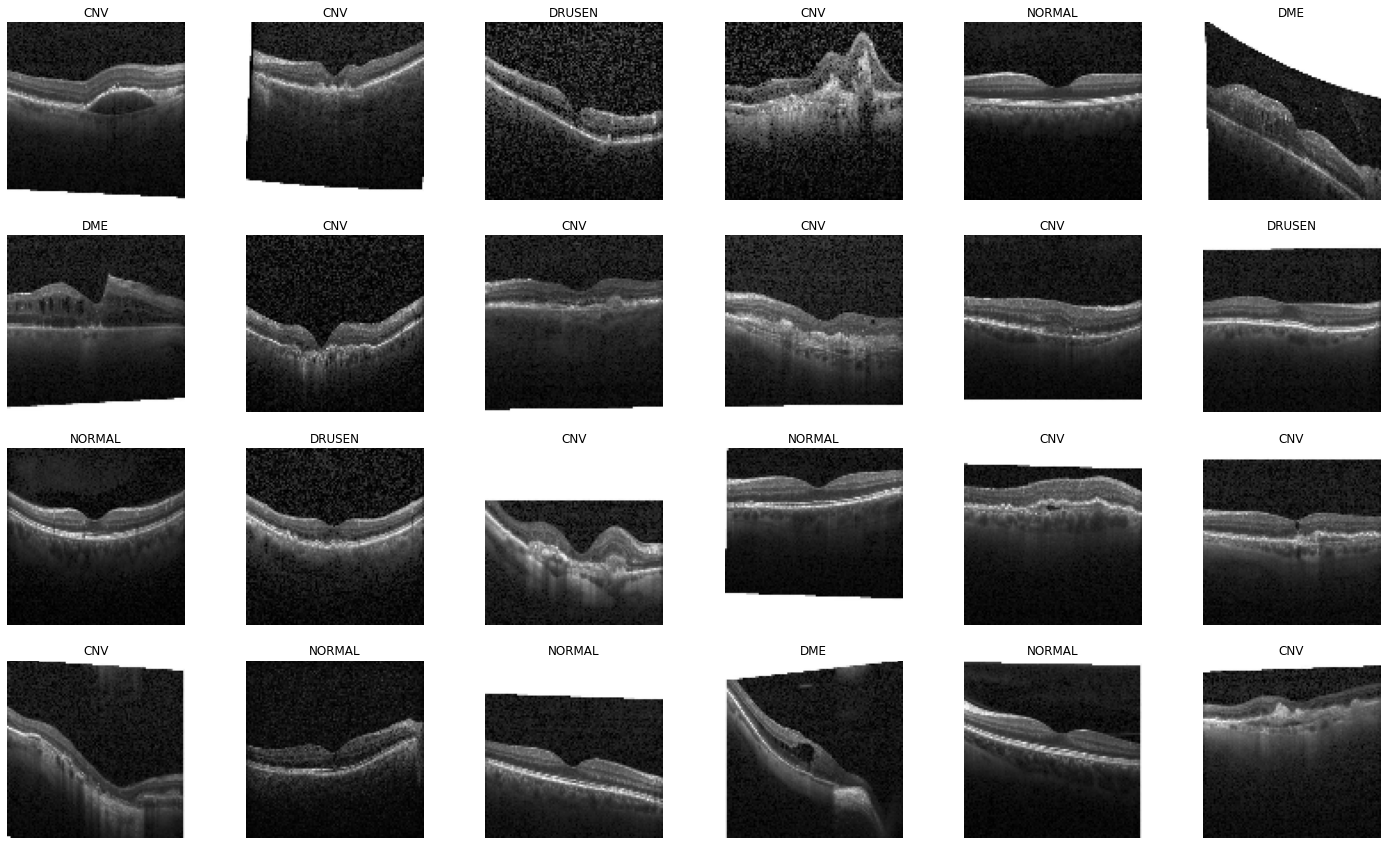

In [11]:
plt.figure(figsize=(25, 15))
for image, label in train_data.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i+1)
        plt.imshow(image[i].numpy().astype('uint8'), cmap='gray')
        plt.title(classes[label[i]])
        plt.axis('off')
        
plt.show()

In [12]:
print('\n[ TRAIN DATA ]')
train_data = get_dataset(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=imgSize,
    color_mode=color_mode,
    batch_size=batch_size,
    shuffle=True,
    seed=0)

print('\n[ VALIDATION DATA ]')
val_data = get_dataset(
    val_path,
    labels='inferred',
    label_mode='categorical',
    image_size=imgSize,
    color_mode=color_mode,
    batch_size=batch_size,
    shuffle=True,
    seed=0)

print('\n[ TEST DATA ]')
test_data = get_dataset(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=imgSize,
    color_mode=color_mode,
    batch_size=batch_size,
    shuffle=True,
    seed=0)


[ TRAIN DATA ]
Found 83484 files belonging to 4 classes.

[ VALIDATION DATA ]
Found 32 files belonging to 4 classes.

[ TEST DATA ]
Found 968 files belonging to 4 classes.


## 2.3 Model Training and Evaluation

### 2.3.1 Model from scratch

In [13]:
def makeFCNNplus(num_classes, input_shape, learning_rate):
    
    
    # INPUT LAYER
    input_layer = layers.Input(shape=input_shape, name='input_layer')

    # BLOCK 01
    conv1_01 = layers.Conv2D(32, (3, 3), padding='same', activation='elu', name='conv1_block01') (input_layer)
    conv2_01 = layers.Conv2D(32, (5, 5), padding='same', activation='elu', name='conv2_block01') (input_layer)
    conv3_01 = layers.Conv2D(32, (7, 7), padding='same', activation='elu', name='conv3_block01') (input_layer)
    unit_01 = layers.Concatenate(name='concatenate_1') ([conv1_01, conv2_01, conv3_01])
    conv_final_01 = layers.Conv2D(16, (1, 1), padding='same', activation='relu', name='conv1d_1') (unit_01)
    final_01 = layers.MaxPooling2D((2, 2), name='maxpooling_1') (conv_final_01)

    # BLOCK 02
    conv1_02 = layers.Conv2D(64, (3, 3), padding='same', activation='elu', name='conv1_block02') (final_01)
    conv2_02 = layers.Conv2D(64, (5, 5), padding='same', activation='elu', name='conv2_block02') (final_01)
    conv3_02 = layers.Conv2D(64, (7, 7), padding='same', activation='elu', name='conv3_block02') (final_01)
    unit_02 = layers.Concatenate(name='concatenate_2') ([conv1_02, conv2_02, conv3_02])
    conv_final_02 = layers.Conv2D(32, (1, 1), padding='same', activation='relu', name='conv1d_2') (unit_02)
    final_02 = layers.MaxPooling2D((2, 2), name='maxpooling_2') (conv_final_02)

    # CLASSIFICATION BLOCK
    vectorized = layers.Flatten(name='flatten') (final_02)
    dropout_1 = layers.Dropout(0.5, name='dropout_1') (vectorized)
    dense_2 = layers.Dense(64, activation='relu', name='dense_1') (dropout_1)
    dropout_2 = layers.Dropout(0.5, name='dropout_2') (dense_2)

    # OUTPUT LAYER
    output_layer = layers.Dense(num_classes, activation='softmax', name='softmax') (dropout_2)

    model = models.Model(inputs=input_layer, outputs=output_layer, name='FCNNplus')

    model.compile(
        loss=CategoricalCrossentropy(),
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

    return model

<center> <img src="notebook_images/FCNNplus.png" style="max-width:90%"> </center>
<center> Figure 2. Proposed architecture. </center>

In [14]:
model_1 = makeFCNNplus(4, (100, 100, 3), l_rate)
model_1.summary()

Model: "FCNNplus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_block01 (Conv2D)          (None, 100, 100, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
conv2_block01 (Conv2D)          (None, 100, 100, 32) 2432        input_layer[0][0]                
__________________________________________________________________________________________________
conv3_block01 (Conv2D)          (None, 100, 100, 32) 4736        input_layer[0][0]                
___________________________________________________________________________________________

In [15]:
history_1 = model_1.fit(
    train_data,
    validation_data=val_data,
    epochs=25)

Epoch 1/25
653/653 [==============================] - 188s 273ms/step - loss: 1.1260 - acc: 0.6246 - prec: 0.7843 - rec: 0.4222 - auc: 0.8277 - val_loss: 0.9678 - val_acc: 0.5000 - val_prec: 0.7143 - val_rec: 0.4688 - val_auc: 0.8488
Epoch 2/25
653/653 [==============================] - 132s 200ms/step - loss: 0.6737 - acc: 0.7539 - prec: 0.8476 - rec: 0.6559 - auc: 0.9247 - val_loss: 0.6721 - val_acc: 0.6562 - val_prec: 0.6667 - val_rec: 0.5625 - val_auc: 0.9188
Epoch 3/25
653/653 [==============================] - 131s 198ms/step - loss: 0.5604 - acc: 0.8015 - prec: 0.8610 - rec: 0.7292 - auc: 0.9476 - val_loss: 0.5784 - val_acc: 0.7812 - val_prec: 0.7931 - val_rec: 0.7188 - val_auc: 0.9435
Epoch 4/25
653/653 [==============================] - 132s 199ms/step - loss: 0.4910 - acc: 0.8264 - prec: 0.8709 - rec: 0.7751 - auc: 0.9591 - val_loss: 0.3529 - val_acc: 0.9062 - val_prec: 0.9032 - val_rec: 0.8750 - val_auc: 0.9805
Epoch 5/25
653/653 [==============================] - 132s 200ms

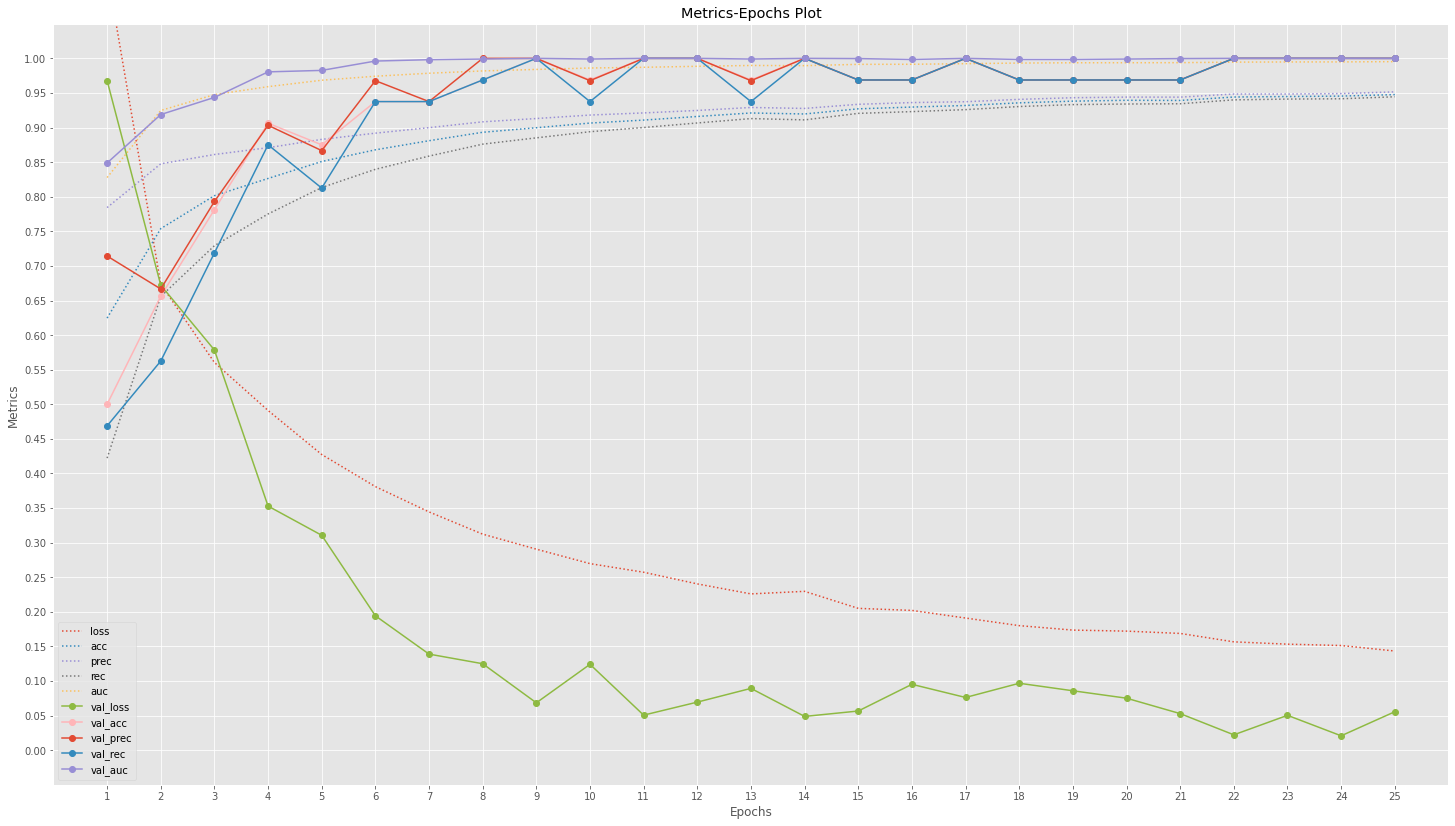

In [16]:
history_log_1 = history_1.history
metrics_1 = list(history_log_1.keys())
epochs = range(1, len(history_log_1[metrics_1[0]]) + 1)

from matplotlib import style

plt.figure(figsize=(25,14))
style.use('ggplot')

for metric in metrics_1:
    if metric.startswith('val'):
        plt.plot(epochs, history_log_1[metric], marker='o', label=metric)
    else:
        plt.plot(epochs, history_log_1[metric], linestyle='dotted', label=metric)
        
plt.xlabel('Epochs')
plt.xlim([0, epochs[-1] + 1])
plt.xticks(np.arange(1, epochs[-1] + 1))
plt.ylabel('Metrics')
plt.ylim([-0.05,1.05])
plt.yticks(np.arange(0,1.01, step=0.05))
plt.title('Metrics-Epochs Plot')

plt.legend()

plt.show()

In [17]:
test_results_1 = model_1.evaluate(test_data)

8/8 [==============================] - 2s 47ms/step - loss: 0.0454 - acc: 0.9845 - prec: 0.9845 - rec: 0.9835 - auc: 0.9992


In [18]:
model_1.save("/kaggle/working/models_saved/FCNNplus")

### 2.3.2 STANDARD_CNN

In [19]:
model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')], name='STANDARD_CNN')

model_2.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=l_rate),
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

In [20]:
model_2.summary()

Model: "STANDARD_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)            

In [21]:
history_2 = model_2.fit(
    train_data,
    validation_data=val_data,
    epochs=25)

Epoch 1/25
653/653 [==============================] - 127s 191ms/step - loss: 1.2491 - acc: 0.6389 - prec: 0.7482 - rec: 0.4932 - auc: 0.8338 - val_loss: 0.8568 - val_acc: 0.5625 - val_prec: 0.7273 - val_rec: 0.5000 - val_auc: 0.8586
Epoch 2/25
653/653 [==============================] - 124s 188ms/step - loss: 0.6995 - acc: 0.7414 - prec: 0.8321 - rec: 0.6485 - auc: 0.9177 - val_loss: 0.8951 - val_acc: 0.6250 - val_prec: 0.6957 - val_rec: 0.5000 - val_auc: 0.8607
Epoch 3/25
653/653 [==============================] - 125s 189ms/step - loss: 0.6042 - acc: 0.7810 - prec: 0.8456 - rec: 0.7110 - auc: 0.9388 - val_loss: 0.5372 - val_acc: 0.7500 - val_prec: 0.7931 - val_rec: 0.7188 - val_auc: 0.9448
Epoch 4/25
653/653 [==============================] - 129s 193ms/step - loss: 0.5210 - acc: 0.8132 - prec: 0.8569 - rec: 0.7626 - auc: 0.9537 - val_loss: 0.4387 - val_acc: 0.7812 - val_prec: 0.8065 - val_rec: 0.7812 - val_auc: 0.9642
Epoch 5/25
653/653 [==============================] - 124s 188ms

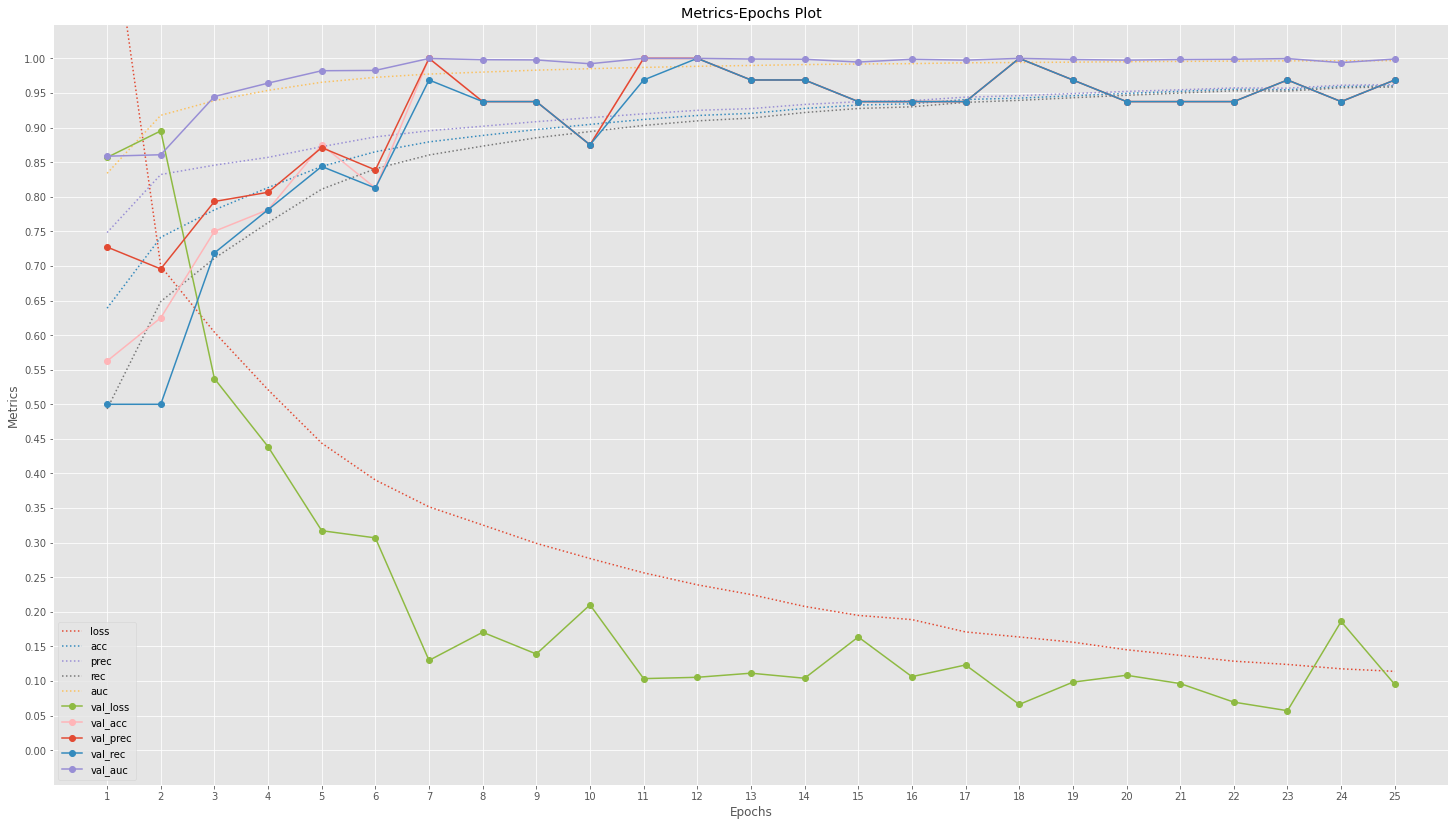

In [22]:
history_log_2 = history_2.history
metrics_2 = list(history_log_2.keys())
epochs = range(1, len(history_log_2[metrics_2[0]]) + 1)

from matplotlib import style

plt.figure(figsize=(25,14))
style.use('ggplot')

for metric in metrics_2:
    if metric.startswith('val'):
        plt.plot(epochs, history_log_2[metric], marker='o', label=metric)
    else:
        plt.plot(epochs, history_log_2[metric], linestyle='dotted', label=metric)
        
plt.xlabel('Epochs')
plt.xlim([0, epochs[-1] + 1])
plt.xticks(np.arange(1, epochs[-1] + 1))
plt.ylabel('Metrics')
plt.ylim([-0.05,1.05])
plt.yticks(np.arange(0,1.01, step=0.05))
plt.title('Metrics-Epochs Plot')

plt.legend()

plt.show()

In [23]:
test_results_2 = model_2.evaluate(test_data)

8/8 [==============================] - 1s 24ms/step - loss: 0.0523 - acc: 0.9845 - prec: 0.9845 - rec: 0.9835 - auc: 0.9996


In [24]:
model_2.save("/kaggle/working/models_saved/STANDARD_CNN")

### 2.3.3 VGG16 - State of Art Model

In [25]:
model_3 = VGG16(include_top=True,input_shape=(100, 100, 3), classes=4, weights=None, classifier_activation='softmax')

model_3.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=l_rate),
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

In [26]:
model_3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [27]:
history_3 = model_3.fit(
    train_data,
    validation_data=val_data,
    epochs=25)

Epoch 1/25
653/653 [==============================] - 153s 226ms/step - loss: 0.5840 - acc: 0.7797 - prec: 0.8609 - rec: 0.7060 - auc: 0.9429 - val_loss: 0.0888 - val_acc: 0.9375 - val_prec: 0.9677 - val_rec: 0.9375 - val_auc: 0.9989
Epoch 2/25
653/653 [==============================] - 147s 223ms/step - loss: 0.2387 - acc: 0.9216 - prec: 0.9270 - rec: 0.9165 - auc: 0.9881 - val_loss: 0.0409 - val_acc: 1.0000 - val_prec: 1.0000 - val_rec: 1.0000 - val_auc: 1.0000
Epoch 3/25
653/653 [==============================] - 148s 224ms/step - loss: 0.1813 - acc: 0.9399 - prec: 0.9432 - rec: 0.9371 - auc: 0.9926 - val_loss: 0.0633 - val_acc: 1.0000 - val_prec: 1.0000 - val_rec: 1.0000 - val_auc: 1.0000
Epoch 4/25
653/653 [==============================] - 147s 223ms/step - loss: 0.1516 - acc: 0.9495 - prec: 0.9517 - rec: 0.9474 - auc: 0.9945 - val_loss: 0.0246 - val_acc: 1.0000 - val_prec: 1.0000 - val_rec: 1.0000 - val_auc: 1.0000
Epoch 5/25
653/653 [==============================] - 148s 224ms

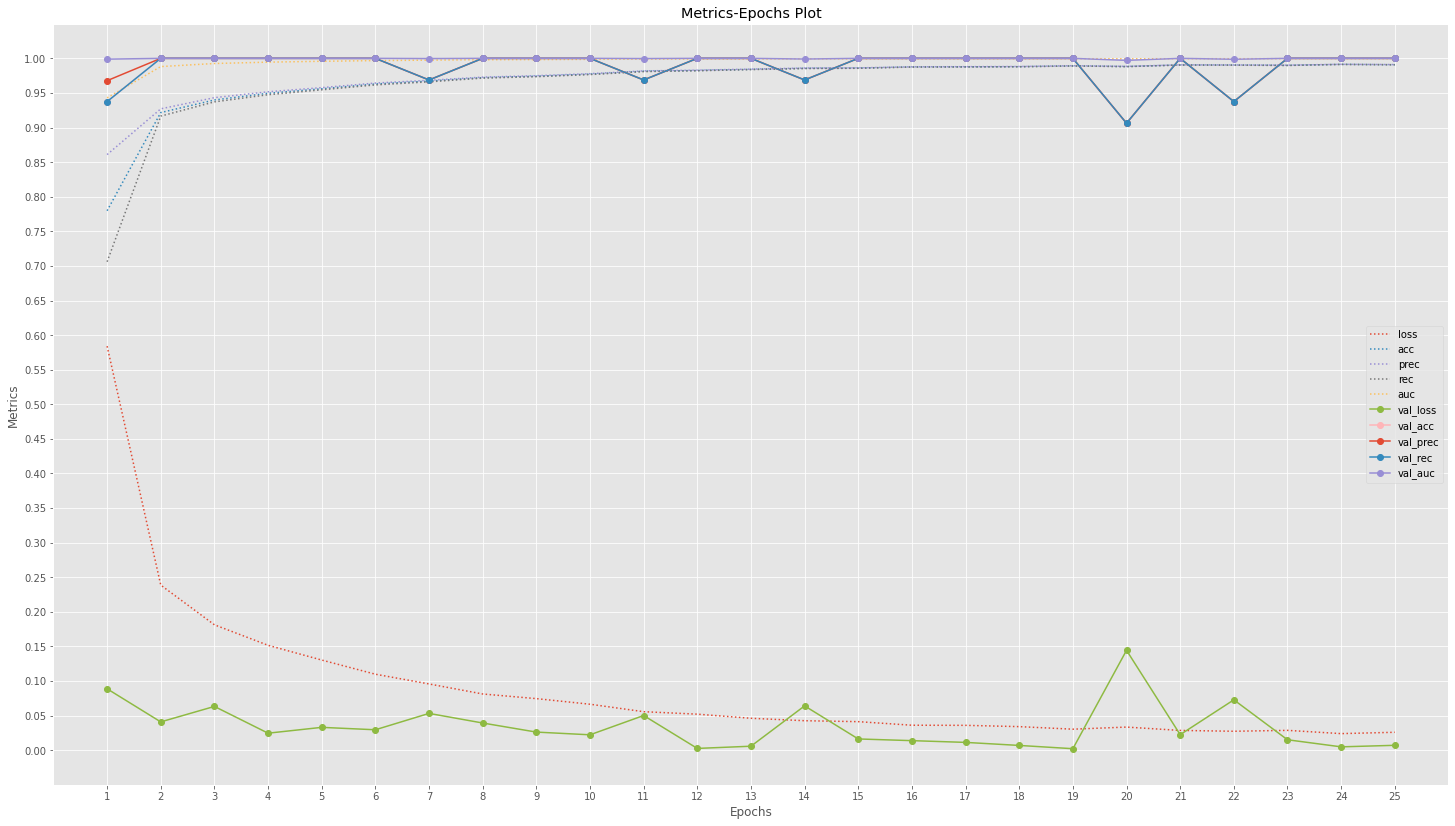

In [28]:
history_log_3 = history_3.history
metrics_3 = list(history_log_3.keys())
epochs = range(1, len(history_log_3[metrics_3[0]]) + 1)

from matplotlib import style

plt.figure(figsize=(25,14))
style.use('ggplot')

for metric in metrics_3:
    if metric.startswith('val'):
        plt.plot(epochs, history_log_3[metric], marker='o', label=metric)
    else:
        plt.plot(epochs, history_log_3[metric], linestyle='dotted', label=metric)
        
plt.xlabel('Epochs')
plt.xlim([0, epochs[-1] + 1])
plt.xticks(np.arange(1, epochs[-1] + 1))
plt.ylabel('Metrics')
plt.ylim([-0.05,1.05])
plt.yticks(np.arange(0,1.01, step=0.05))
plt.title('Metrics-Epochs Plot')

plt.legend()

plt.show()

In [29]:
test_results_3 = model_3.evaluate(test_data)

8/8 [==============================] - 4s 261ms/step - loss: 0.0219 - acc: 0.9917 - prec: 0.9917 - rec: 0.9897 - auc: 0.9999


In [30]:
model_3.save("/kaggle/working/models_saved/VGG16")

### 2.3.4 VGG19 - State of Art Model

In [31]:
model_4 = VGG19(include_top=True,input_shape=(100, 100, 3), classes=4, weights=None, classifier_activation='softmax')

model_4.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=l_rate),
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

In [32]:
model_4.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [33]:
history_4 = model_4.fit(
    train_data,
    validation_data=val_data,
    epochs=25)

Epoch 1/25
653/653 [==============================] - 196s 295ms/step - loss: 1.2386 - acc: 0.4441 - prec: 0.5281 - rec: 0.0331 - auc: 0.7030 - val_loss: 1.5648 - val_acc: 0.2500 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000
Epoch 2/25
653/653 [==============================] - 154s 233ms/step - loss: 1.2355 - acc: 0.4458 - prec: 0.4544 - rec: 0.0100 - auc: 0.7018 - val_loss: 1.5427 - val_acc: 0.2500 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000
Epoch 3/25
653/653 [==============================] - 152s 229ms/step - loss: 1.2394 - acc: 0.4446 - prec: 0.5285 - rec: 0.0369 - auc: 0.7038 - val_loss: 1.5549 - val_acc: 0.2500 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000
Epoch 4/25
653/653 [==============================] - 152s 231ms/step - loss: 1.2189 - acc: 0.4588 - prec: 0.5789 - rec: 0.0680 - auc: 0.7140 - val_loss: 1.2580 - val_acc: 0.5000 - val_prec: 0.6818 - val_rec: 0.4688 - val_auc: 0.6720
Epoch 5/25
653/653 [====================

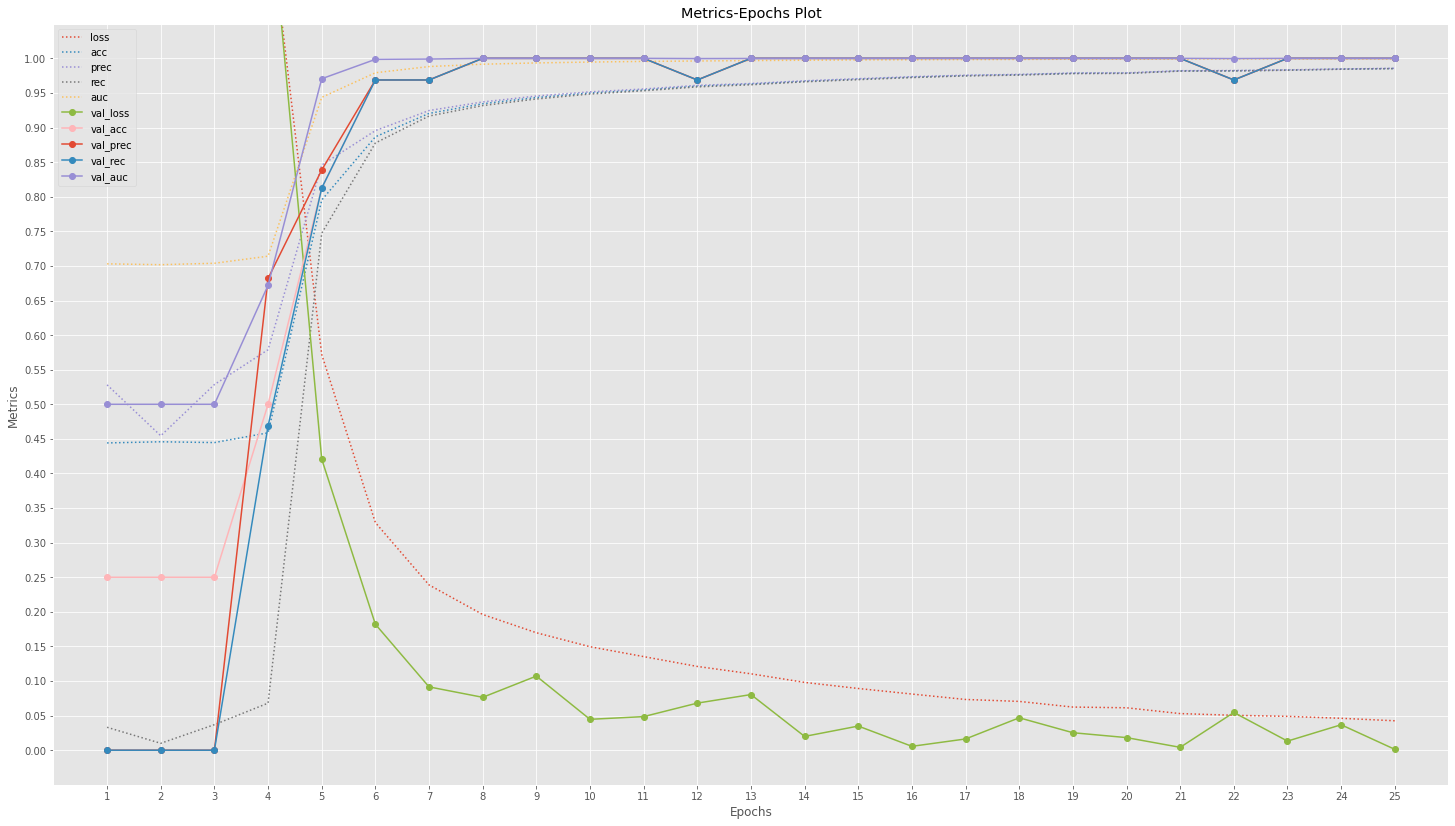

In [34]:
history_log_4 = history_4.history
metrics_4 = list(history_log_4.keys())
epochs = range(1, len(history_log_4[metrics_4[0]]) + 1)

from matplotlib import style

plt.figure(figsize=(25,14))
style.use('ggplot')

for metric in metrics_4:
    if metric.startswith('val'):
        plt.plot(epochs, history_log_4[metric], marker='o', label=metric)
    else:
        plt.plot(epochs, history_log_4[metric], linestyle='dotted', label=metric)
        
plt.xlabel('Epochs')
plt.xlim([0, epochs[-1] + 1])
plt.xticks(np.arange(1, epochs[-1] + 1))
plt.ylabel('Metrics')
plt.ylim([-0.05,1.05])
plt.yticks(np.arange(0,1.01, step=0.05))
plt.title('Metrics-Epochs Plot')

plt.legend()

plt.show()

In [35]:
test_results_4 = model_4.evaluate(test_data)

8/8 [==============================] - 3s 67ms/step - loss: 0.0325 - acc: 0.9948 - prec: 0.9948 - rec: 0.9948 - auc: 0.9985


In [36]:
model_4.save("/kaggle/working/models_saved/VGG19")

### 2.3.5 EfficientNetB0 - State of Art Model

In [37]:
model_5 = EfficientNetB0(include_top=True,input_shape=(100, 100, 3), classes=4, weights=None, classifier_activation='softmax')

model_5.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=l_rate),
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

In [38]:
model_5.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 100, 100, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 100, 100, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 101, 101, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [39]:
history_5 = model_5.fit(
    train_data,
    validation_data=val_data,
    epochs=25)

Epoch 1/25
653/653 [==============================] - 193s 279ms/step - loss: 1.6211 - acc: 0.4613 - prec: 0.5140 - rec: 0.2746 - auc: 0.6992 - val_loss: 1.3961 - val_acc: 0.4688 - val_prec: 0.5556 - val_rec: 0.4688 - val_auc: 0.6580
Epoch 2/25
653/653 [==============================] - 165s 250ms/step - loss: 1.1767 - acc: 0.6179 - prec: 0.7018 - rec: 0.4952 - auc: 0.8116 - val_loss: 1.0170 - val_acc: 0.5000 - val_prec: 0.6154 - val_rec: 0.5000 - val_auc: 0.8366
Epoch 3/25
653/653 [==============================] - 164s 248ms/step - loss: 0.9008 - acc: 0.6873 - prec: 0.7849 - rec: 0.5886 - auc: 0.8778 - val_loss: 0.9142 - val_acc: 0.5625 - val_prec: 0.6957 - val_rec: 0.5000 - val_auc: 0.8582
Epoch 4/25
653/653 [==============================] - 165s 250ms/step - loss: 0.7030 - acc: 0.7387 - prec: 0.8238 - rec: 0.6554 - auc: 0.9181 - val_loss: 0.8340 - val_acc: 0.5938 - val_prec: 0.7083 - val_rec: 0.5312 - val_auc: 0.8859
Epoch 5/25
653/653 [==============================] - 164s 249ms

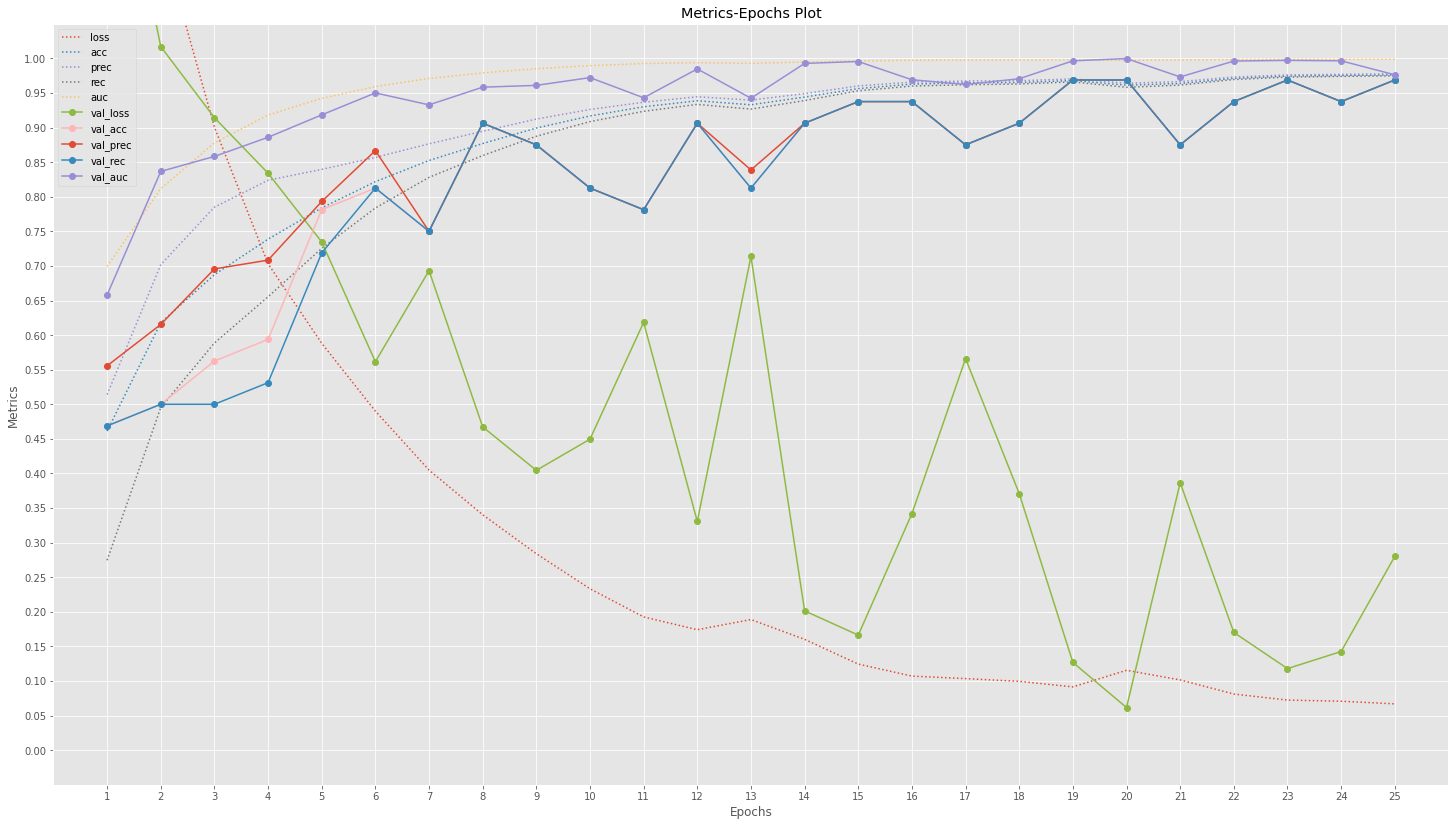

In [40]:
history_log_5 = history_5.history
metrics_5 = list(history_log_5.keys())
epochs = range(1, len(history_log_5[metrics_5[0]]) + 1)

from matplotlib import style

plt.figure(figsize=(25,14))
style.use('ggplot')

for metric in metrics_5:
    if metric.startswith('val'):
        plt.plot(epochs, history_log_5[metric], marker='o', label=metric)
    else:
        plt.plot(epochs, history_log_5[metric], linestyle='dotted', label=metric)
        
plt.xlabel('Epochs')
plt.xlim([0, epochs[-1] + 1])
plt.xticks(np.arange(1, epochs[-1] + 1))
plt.ylabel('Metrics')
plt.ylim([-0.05,1.05])
plt.yticks(np.arange(0,1.01, step=0.05))
plt.title('Metrics-Epochs Plot')

plt.legend()

plt.show()

In [41]:
test_results_5 = model_5.evaluate(test_data)

8/8 [==============================] - 2s 66ms/step - loss: 0.1236 - acc: 0.9628 - prec: 0.9628 - rec: 0.9628 - auc: 0.9963


In [42]:
model_5.save("/kaggle/working/models_saved/EfficientNetB0")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### 2.3.6 InceptionV3 - State of Art Model

In [43]:
model_6 = InceptionV3(include_top=True,input_shape=(100, 100, 3), classes=4, weights=None, classifier_activation='softmax')

model_6.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=l_rate),
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

In [44]:
model_6.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 49, 49, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [45]:
history_6 = model_6.fit(
    train_data,
    validation_data=val_data,
    epochs=25)

Epoch 1/25
653/653 [==============================] - 165s 237ms/step - loss: 0.6276 - acc: 0.7694 - prec: 0.8237 - rec: 0.7169 - auc: 0.9336 - val_loss: 0.5466 - val_acc: 0.7500 - val_prec: 0.7500 - val_rec: 0.7500 - val_auc: 0.9523
Epoch 2/25
653/653 [==============================] - 151s 229ms/step - loss: 0.3714 - acc: 0.8664 - prec: 0.8834 - rec: 0.8509 - auc: 0.9750 - val_loss: 0.1141 - val_acc: 0.9375 - val_prec: 0.9375 - val_rec: 0.9375 - val_auc: 0.9987
Epoch 3/25
653/653 [==============================] - 152s 230ms/step - loss: 0.2799 - acc: 0.9011 - prec: 0.9106 - rec: 0.8929 - auc: 0.9850 - val_loss: 0.4127 - val_acc: 0.8750 - val_prec: 0.8750 - val_rec: 0.8750 - val_auc: 0.9767
Epoch 4/25
653/653 [==============================] - 153s 232ms/step - loss: 0.2319 - acc: 0.9180 - prec: 0.9235 - rec: 0.9123 - auc: 0.9893 - val_loss: 0.1679 - val_acc: 0.9062 - val_prec: 0.9667 - val_rec: 0.9062 - val_auc: 0.9967
Epoch 5/25
653/653 [==============================] - 152s 231ms

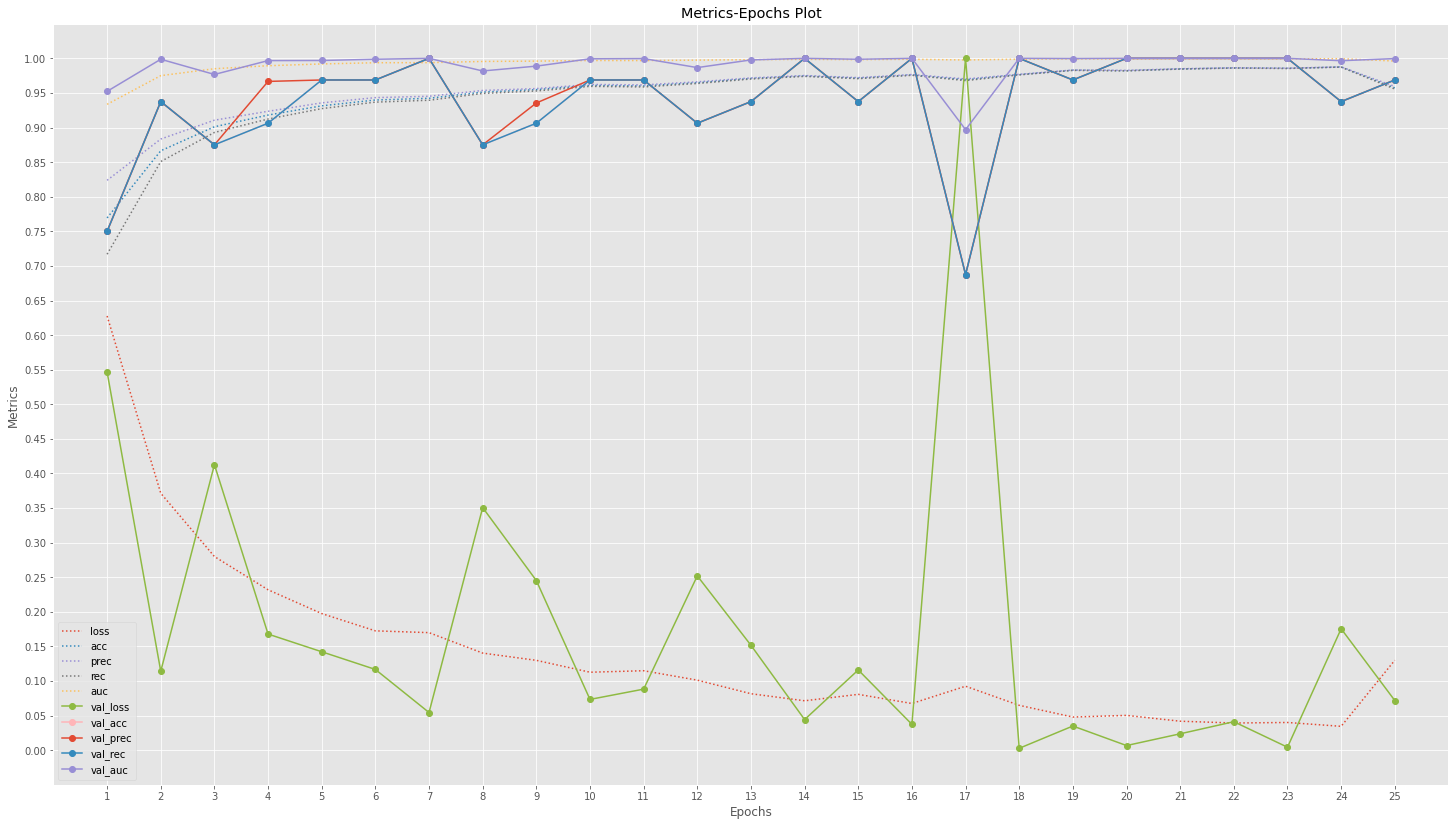

In [46]:
history_log_6 = history_6.history
metrics_6 = list(history_log_6.keys())
epochs = range(1, len(history_log_6[metrics_6[0]]) + 1)

from matplotlib import style

plt.figure(figsize=(25,14))
style.use('ggplot')

for metric in metrics_6:
    if metric.startswith('val'):
        plt.plot(epochs, history_log_6[metric], marker='o', label=metric)
    else:
        plt.plot(epochs, history_log_6[metric], linestyle='dotted', label=metric)
        
plt.xlabel('Epochs')
plt.xlim([0, epochs[-1] + 1])
plt.xticks(np.arange(1, epochs[-1] + 1))
plt.ylabel('Metrics')
plt.ylim([-0.05,1.05])
plt.yticks(np.arange(0,1.01, step=0.05))
plt.title('Metrics-Epochs Plot')

plt.legend()

plt.show()

In [47]:
test_results_6 = model_6.evaluate(test_data)

8/8 [==============================] - 2s 88ms/step - loss: 0.0190 - acc: 0.9959 - prec: 0.9959 - rec: 0.9959 - auc: 0.9999


In [48]:
model_6.save("/kaggle/working/models_saved/InceptionV3")

### 2.3.7 Xception - State od Art Model

In [49]:
model_7 = Xception(include_top=True,input_shape=(100, 100, 3), classes=4, weights=None, classifier_activation='softmax')

model_7.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=l_rate),
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

In [50]:
model_7.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [51]:
history_7 = model_7.fit(
    train_data,
    validation_data=val_data,
    epochs=25)

Epoch 1/25
653/653 [==============================] - 190s 280ms/step - loss: 0.4198 - acc: 0.8462 - prec: 0.8748 - rec: 0.8201 - auc: 0.9690 - val_loss: 0.7991 - val_acc: 0.6562 - val_prec: 0.8261 - val_rec: 0.5938 - val_auc: 0.9001
Epoch 2/25
653/653 [==============================] - 181s 275ms/step - loss: 0.2287 - acc: 0.9199 - prec: 0.9258 - rec: 0.9142 - auc: 0.9894 - val_loss: 0.2817 - val_acc: 0.9688 - val_prec: 0.9677 - val_rec: 0.9375 - val_auc: 0.9852
Epoch 3/25
653/653 [==============================] - 181s 274ms/step - loss: 0.1686 - acc: 0.9414 - prec: 0.9445 - rec: 0.9382 - auc: 0.9937 - val_loss: 0.0975 - val_acc: 1.0000 - val_prec: 1.0000 - val_rec: 1.0000 - val_auc: 1.0000
Epoch 4/25
653/653 [==============================] - 182s 276ms/step - loss: 0.1312 - acc: 0.9539 - prec: 0.9562 - rec: 0.9521 - auc: 0.9959 - val_loss: 0.0485 - val_acc: 1.0000 - val_prec: 1.0000 - val_rec: 1.0000 - val_auc: 1.0000
Epoch 5/25
653/653 [==============================] - 182s 276ms

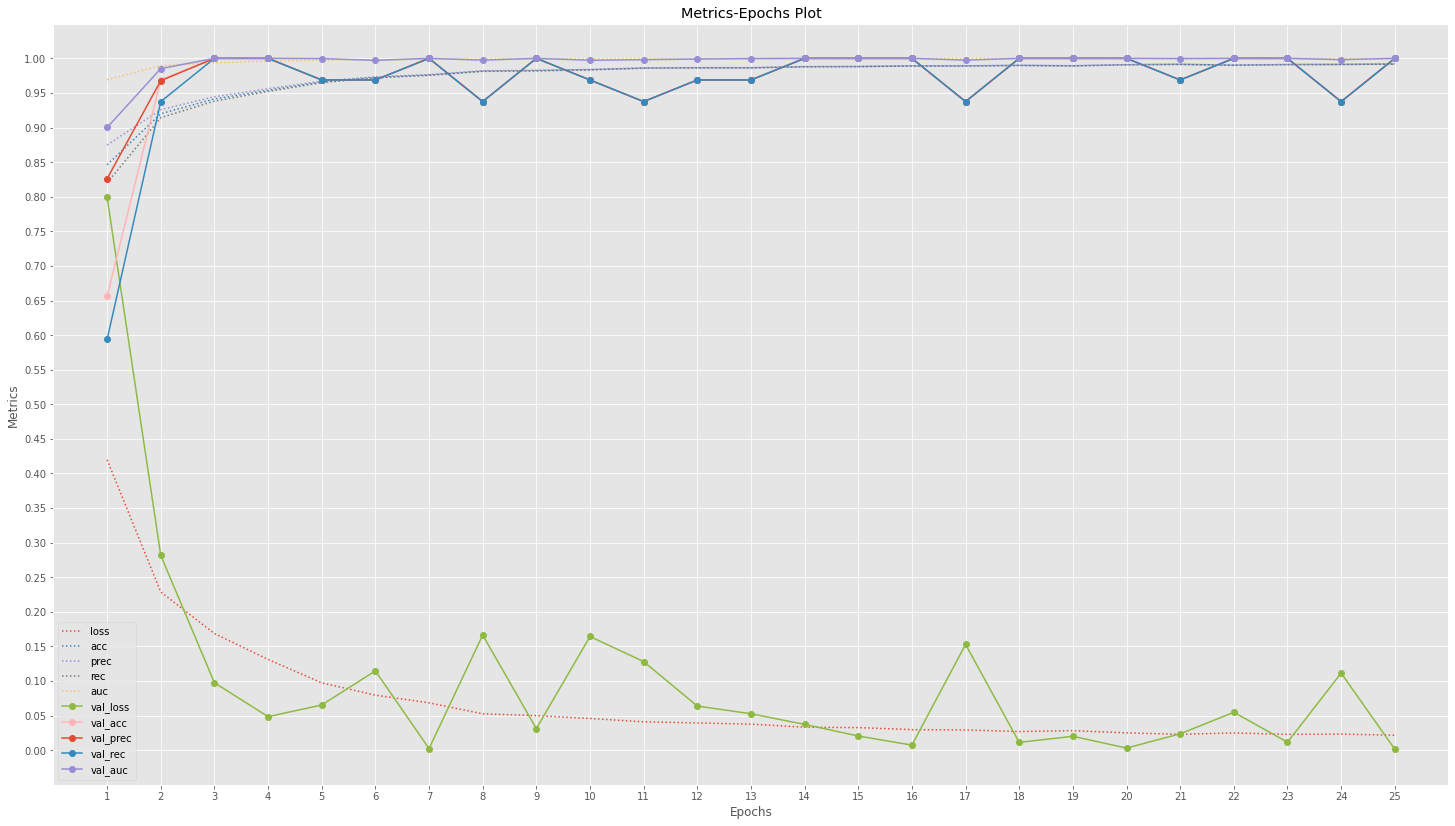

In [52]:
history_log_7 = history_7.history
metrics_7 = list(history_log_7.keys())
epochs = range(1, len(history_log_7[metrics_7[0]]) + 1)

from matplotlib import style

plt.figure(figsize=(25,14))
style.use('ggplot')

for metric in metrics_7:
    if metric.startswith('val'):
        plt.plot(epochs, history_log_7[metric], marker='o', label=metric)
    else:
        plt.plot(epochs, history_log_7[metric], linestyle='dotted', label=metric)
        
plt.xlabel('Epochs')
plt.xlim([0, epochs[-1] + 1])
plt.xticks(np.arange(1, epochs[-1] + 1))
plt.ylabel('Metrics')
plt.ylim([-0.05,1.05])
plt.yticks(np.arange(0,1.01, step=0.05))
plt.title('Metrics-Epochs Plot')

plt.legend()

plt.show()

In [53]:
test_results_7 = model_7.evaluate(test_data)

8/8 [==============================] - 2s 88ms/step - loss: 0.0241 - acc: 0.9866 - prec: 0.9866 - rec: 0.9866 - auc: 0.9992


In [54]:
model_7.save("/kaggle/working/models_saved/Xception")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# 3. GradCAM Application

In [73]:
def image_process(image_path, shape=100):
    
    image = cv2.imread(image_path)
    image_tensor = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = cv2.resize(image_tensor, (shape, shape))
    image_tensor = np.expand_dims(image_tensor, axis=0)
    image_tensor = image_tensor.reshape(-1, shape, shape, 3)
    
    return image, image_tensor

In [85]:
drusen_image = '/kaggle/input/kermany2018/OCT2017 /test/DRUSEN/DRUSEN-1083159-1.jpeg'
cnv_image = '/kaggle/input/kermany2018/OCT2017 /test/CNV/CNV-1016042-1.jpeg'
dme_image = '/kaggle/input/kermany2018/OCT2017 /test/DME/DME-1102486-4.jpeg'

drusen, drusen_tensor = image_process(drusen_image)
cnv, cnv_tensor = image_process(cnv_image)
dme, dme_tensor = image_process(dme_image)

drusen_H, drusen_W, _ = drusen.shape
cnv_H, cnv_W, _ = cnv.shape
dme_H, dme_W, _ = dme.shape

In [86]:
classes = train_data.class_names

for index, name in enumerate(classes):
    print(f"{index} = {name}", end=' ||| ')

0 = CNV ||| 1 = DME ||| 2 = DRUSEN ||| 3 = NORMAL ||| 

## 3.1 Original images

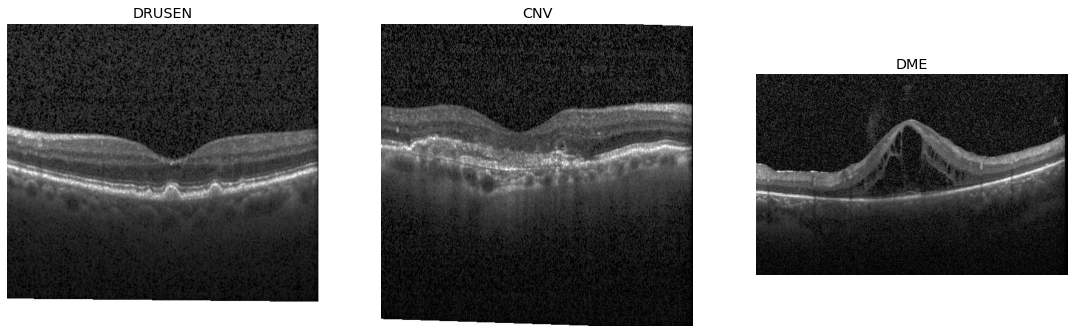

In [87]:
plt.figure(figsize=(19,14))

plt.subplot(1,3,1)
plt.imshow(drusen)
plt.axis('off')
plt.title('DRUSEN')

plt.subplot(1,3,2)
plt.imshow(cnv)
plt.axis('off')
plt.title('CNV')

plt.subplot(1,3,3)
plt.imshow(dme)
plt.axis('off')
plt.title('DME')

plt.show()

## 3.2 FCNNplus

In [88]:
pred_1_drusen = model_1.predict(drusen_tensor)
i_1_drusen = np.argmax(pred_1_drusen)
print('DRUSEN class image predicted as class {} image with confidence equal to {}'.format(i_1_drusen, round(pred_1_drusen[0][i_1_drusen], 2)))

pred_1_cnv = model_1.predict(cnv_tensor)
i_1_cnv = np.argmax(pred_1_cnv)
print('CNV class image predicted as class {} image with confidence equal to {}'.format(i_1_cnv, round(pred_1_cnv[0][i_1_cnv], 2)))
      
pred_1_dme = model_1.predict(dme_tensor)
i_1_dme = np.argmax(pred_1_dme)
print('DME class image predicted as class {} image with confidence equal to {}'.format(i_1_dme, round(pred_1_dme[0][i_1_dme], 2)))

DRUSEN class image predicted as class 2 image with confidence equal to 0.9900000095367432
CNV class image predicted as class 0 image with confidence equal to 1.0
DME class image predicted as class 1 image with confidence equal to 0.9900000095367432


In [89]:
icam_drusen = GradCAM(model_1, i_1_drusen)
heatmap = icam_drusen.compute_heatmap(drusen_tensor)
heatmap = cv2.resize(heatmap, (drusen_W, drusen_H))
overlap_drusen = icam_drusen.overlay_heatmap(heatmap, drusen, alpha=0.5)
overlap_drusen = np.asarray(overlap_drusen)

icam_cnv = GradCAM(model_1, i_1_cnv)
heatmap = icam_cnv.compute_heatmap(cnv_tensor)
heatmap = cv2.resize(heatmap, (cnv_W, cnv_H))
overlap_cnv = icam_drusen.overlay_heatmap(heatmap, cnv, alpha=0.5)
overlap_cnv = np.asarray(overlap_cnv)

icam_dme = GradCAM(model_1, i_1_dme)
heatmap = icam_dme.compute_heatmap(dme_tensor)
heatmap = cv2.resize(heatmap, (dme_W, dme_H))
overlap_dme = icam_dme.overlay_heatmap(heatmap, dme, alpha=0.5)
overlap_dme = np.asarray(overlap_dme)

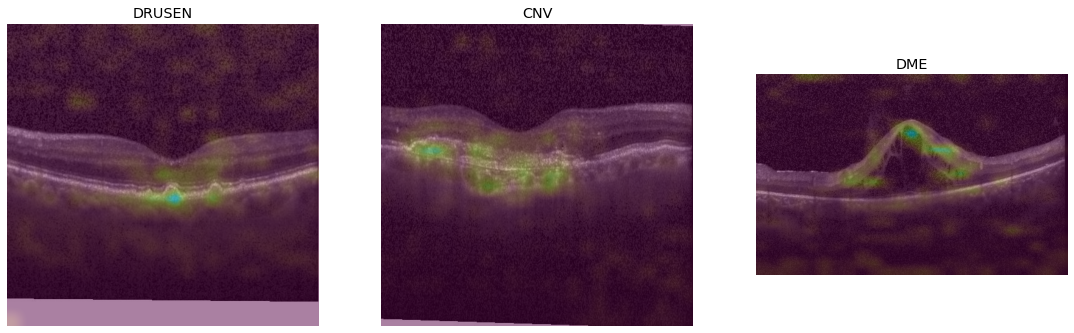

In [90]:
plt.figure(figsize=(19,14))

plt.subplot(1,3,1)
plt.imshow(overlap_drusen[1])
plt.axis('off')
plt.title('DRUSEN')

plt.subplot(1,3,2)
plt.imshow(overlap_cnv[1])
plt.axis('off')
plt.title('CNV')

plt.subplot(1,3,3)
plt.imshow(overlap_dme[1])
plt.axis('off')
plt.title('DME')

plt.show()

## 3.3 STANDARD_CNN

In [91]:
pred_2_drusen = model_2.predict(drusen_tensor)
i_2_drusen = np.argmax(pred_2_drusen)
print('DRUSEN class image predicted as class {} image with confidence equal to {}'.format(i_2_drusen, round(pred_2_drusen[0][i_2_drusen], 2)))

pred_2_cnv = model_2.predict(cnv_tensor)
i_2_cnv = np.argmax(pred_2_cnv)
print('CNV class image predicted as class {} image with confidence equal to {}'.format(i_2_cnv, round(pred_2_cnv[0][i_2_cnv], 2)))
      
pred_2_dme = model_2.predict(dme_tensor)
i_2_dme = np.argmax(pred_2_dme)
print('DME class image predicted as class {} image with confidence equal to {}'.format(i_2_dme, round(pred_2_dme[0][i_2_dme], 2)))

DRUSEN class image predicted as class 2 image with confidence equal to 1.0
CNV class image predicted as class 0 image with confidence equal to 1.0
DME class image predicted as class 1 image with confidence equal to 1.0


In [92]:
icam_drusen = GradCAM(model_2, i_2_drusen)
heatmap = icam_drusen.compute_heatmap(drusen_tensor)
heatmap = cv2.resize(heatmap, (drusen_W, drusen_H))
overlap_drusen = icam_drusen.overlay_heatmap(heatmap, drusen, alpha=0.5)
overlap_drusen = np.asarray(overlap_drusen)

icam_cnv = GradCAM(model_2, i_2_cnv)
heatmap = icam_cnv.compute_heatmap(cnv_tensor)
heatmap = cv2.resize(heatmap, (cnv_W, cnv_H))
overlap_cnv = icam_drusen.overlay_heatmap(heatmap, cnv, alpha=0.5)
overlap_cnv = np.asarray(overlap_cnv)

icam_dme = GradCAM(model_2, i_2_dme)
heatmap = icam_dme.compute_heatmap(dme_tensor)
heatmap = cv2.resize(heatmap, (dme_W, dme_H))
overlap_dme = icam_dme.overlay_heatmap(heatmap, dme, alpha=0.5)
overlap_dme = np.asarray(overlap_dme)

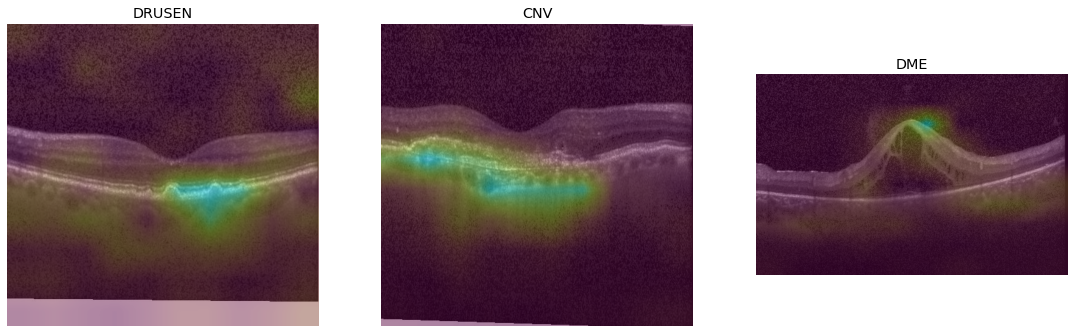

In [93]:
plt.figure(figsize=(19,14))

plt.subplot(1,3,1)
plt.imshow(overlap_drusen[1])
plt.axis('off')
plt.title('DRUSEN')

plt.subplot(1,3,2)
plt.imshow(overlap_cnv[1])
plt.axis('off')
plt.title('CNV')

plt.subplot(1,3,3)
plt.imshow(overlap_dme[1])
plt.axis('off')
plt.title('DME')

plt.show()

## 3.4 VGG16

In [94]:
pred_3_drusen = model_3.predict(drusen_tensor)
i_3_drusen = np.argmax(pred_3_drusen)
print('DRUSEN class image predicted as class {} image with confidence equal to {}'.format(i_3_drusen, round(pred_3_drusen[0][i_3_drusen], 2)))

pred_3_cnv = model_3.predict(cnv_tensor)
i_3_cnv = np.argmax(pred_3_cnv)
print('CNV class image predicted as class {} image with confidence equal to {}'.format(i_3_cnv, round(pred_3_cnv[0][i_3_cnv], 2)))
      
pred_3_dme = model_3.predict(dme_tensor)
i_3_dme = np.argmax(pred_3_dme)
print('DME class image predicted as class {} image with confidence equal to {}'.format(i_3_dme, round(pred_3_dme[0][i_3_dme], 2)))

DRUSEN class image predicted as class 2 image with confidence equal to 1.0
CNV class image predicted as class 0 image with confidence equal to 1.0
DME class image predicted as class 1 image with confidence equal to 1.0


In [95]:
icam_drusen = GradCAM(model_3, i_3_drusen)
heatmap = icam_drusen.compute_heatmap(drusen_tensor)
heatmap = cv2.resize(heatmap, (drusen_W, drusen_H))
overlap_drusen = icam_drusen.overlay_heatmap(heatmap, drusen, alpha=0.5)
overlap_drusen = np.asarray(overlap_drusen)

icam_cnv = GradCAM(model_3, i_3_cnv)
heatmap = icam_cnv.compute_heatmap(cnv_tensor)
heatmap = cv2.resize(heatmap, (cnv_W, cnv_H))
overlap_cnv = icam_drusen.overlay_heatmap(heatmap, cnv, alpha=0.5)
overlap_cnv = np.asarray(overlap_cnv)

icam_dme = GradCAM(model_3, i_3_dme)
heatmap = icam_dme.compute_heatmap(dme_tensor)
heatmap = cv2.resize(heatmap, (dme_W, dme_H))
overlap_dme = icam_dme.overlay_heatmap(heatmap, dme, alpha=0.5)
overlap_dme = np.asarray(overlap_dme)

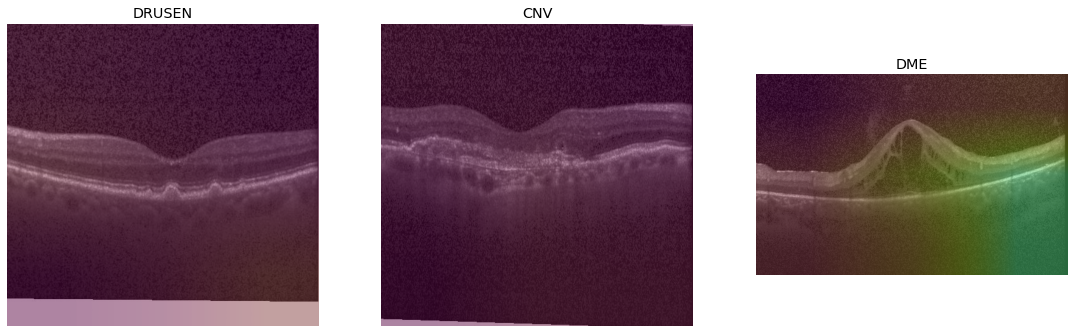

In [96]:
plt.figure(figsize=(19,14))

plt.subplot(1,3,1)
plt.imshow(overlap_drusen[1])
plt.axis('off')
plt.title('DRUSEN')

plt.subplot(1,3,2)
plt.imshow(overlap_cnv[1])
plt.axis('off')
plt.title('CNV')

plt.subplot(1,3,3)
plt.imshow(overlap_dme[1])
plt.axis('off')
plt.title('DME')

plt.show()

## 3.5 VGG19

In [97]:
pred_4_drusen = model_4.predict(drusen_tensor)
i_4_drusen = np.argmax(pred_4_drusen)
print('DRUSEN class image predicted as class {} image with confidence equal to {}'.format(i_4_drusen, round(pred_4_drusen[0][i_4_drusen], 2)))

pred_4_cnv = model_4.predict(cnv_tensor)
i_4_cnv = np.argmax(pred_4_cnv)
print('CNV class image predicted as class {} image with confidence equal to {}'.format(i_4_cnv, round(pred_4_cnv[0][i_4_cnv], 2)))
      
pred_4_dme = model_4.predict(dme_tensor)
i_4_dme = np.argmax(pred_4_dme)
print('DME class image predicted as class {} image with confidence equal to {}'.format(i_4_dme, round(pred_4_dme[0][i_4_dme], 2)))

DRUSEN class image predicted as class 2 image with confidence equal to 1.0
CNV class image predicted as class 0 image with confidence equal to 1.0
DME class image predicted as class 1 image with confidence equal to 1.0


In [98]:
icam_drusen = GradCAM(model_4, i_4_drusen)
heatmap = icam_drusen.compute_heatmap(drusen_tensor)
heatmap = cv2.resize(heatmap, (drusen_W, drusen_H))
overlap_drusen = icam_drusen.overlay_heatmap(heatmap, drusen, alpha=0.5)
overlap_drusen = np.asarray(overlap_drusen)

icam_cnv = GradCAM(model_4, i_4_cnv)
heatmap = icam_cnv.compute_heatmap(cnv_tensor)
heatmap = cv2.resize(heatmap, (cnv_W, cnv_H))
overlap_cnv = icam_drusen.overlay_heatmap(heatmap, cnv, alpha=0.5)
overlap_cnv = np.asarray(overlap_cnv)

icam_dme = GradCAM(model_4, i_4_dme)
heatmap = icam_dme.compute_heatmap(dme_tensor)
heatmap = cv2.resize(heatmap, (dme_W, dme_H))
overlap_dme = icam_dme.overlay_heatmap(heatmap, dme, alpha=0.5)
overlap_dme = np.asarray(overlap_dme)

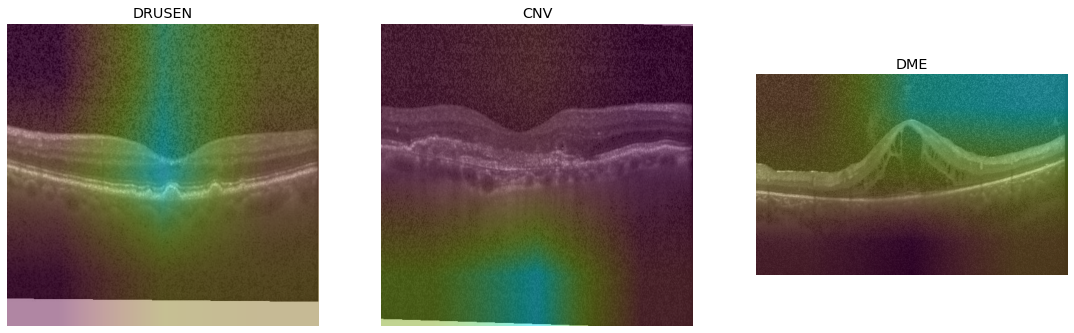

In [99]:
plt.figure(figsize=(19,14))

plt.subplot(1,3,1)
plt.imshow(overlap_drusen[1])
plt.axis('off')
plt.title('DRUSEN')

plt.subplot(1,3,2)
plt.imshow(overlap_cnv[1])
plt.axis('off')
plt.title('CNV')

plt.subplot(1,3,3)
plt.imshow(overlap_dme[1])
plt.axis('off')
plt.title('DME')

plt.show()

## 3.6 EfficientNetB0

In [100]:
pred_5_drusen = model_5.predict(drusen_tensor)
i_5_drusen = np.argmax(pred_5_drusen)
print('DRUSEN class image predicted as class {} image with confidence equal to {}'.format(i_5_drusen, round(pred_5_drusen[0][i_5_drusen], 2)))

pred_5_cnv = model_5.predict(cnv_tensor)
i_5_cnv = np.argmax(pred_5_cnv)
print('CNV class image predicted as class {} image with confidence equal to {}'.format(i_5_cnv, round(pred_5_cnv[0][i_5_cnv], 2)))
      
pred_5_dme = model_5.predict(dme_tensor)
i_5_dme = np.argmax(pred_5_dme)
print('DME class image predicted as class {} image with confidence equal to {}'.format(i_5_dme, round(pred_5_dme[0][i_5_dme], 2)))

DRUSEN class image predicted as class 2 image with confidence equal to 1.0
CNV class image predicted as class 0 image with confidence equal to 1.0
DME class image predicted as class 0 image with confidence equal to 0.6100000143051147


In [101]:
icam_drusen = GradCAM(model_5, i_5_drusen)
heatmap = icam_drusen.compute_heatmap(drusen_tensor)
heatmap = cv2.resize(heatmap, (drusen_W, drusen_H))
overlap_drusen = icam_drusen.overlay_heatmap(heatmap, drusen, alpha=0.5)
overlap_drusen = np.asarray(overlap_drusen)

icam_cnv = GradCAM(model_5, i_5_cnv)
heatmap = icam_cnv.compute_heatmap(cnv_tensor)
heatmap = cv2.resize(heatmap, (cnv_W, cnv_H))
overlap_cnv = icam_drusen.overlay_heatmap(heatmap, cnv, alpha=0.5)
overlap_cnv = np.asarray(overlap_cnv)

icam_dme = GradCAM(model_5, i_5_dme)
heatmap = icam_dme.compute_heatmap(dme_tensor)
heatmap = cv2.resize(heatmap, (dme_W, dme_H))
overlap_dme = icam_dme.overlay_heatmap(heatmap, dme, alpha=0.5)
overlap_dme = np.asarray(overlap_dme)

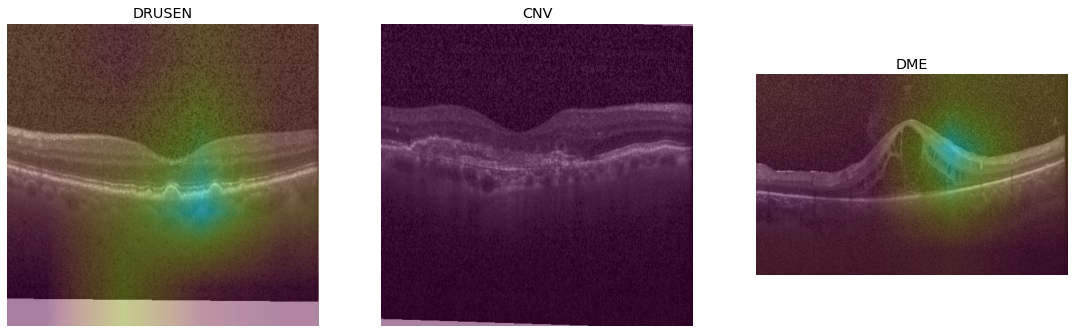

In [102]:
plt.figure(figsize=(19,14))

plt.subplot(1,3,1)
plt.imshow(overlap_drusen[1])
plt.axis('off')
plt.title('DRUSEN')

plt.subplot(1,3,2)
plt.imshow(overlap_cnv[1])
plt.axis('off')
plt.title('CNV')

plt.subplot(1,3,3)
plt.imshow(overlap_dme[1])
plt.axis('off')
plt.title('DME')

plt.show()

## 3.7 InceptionV3

In [103]:
pred_6_drusen = model_6.predict(drusen_tensor)
i_6_drusen = np.argmax(pred_6_drusen)
print('DRUSEN class image predicted as class {} image with confidence equal to {}'.format(i_6_drusen, round(pred_6_drusen[0][i_6_drusen], 2)))

pred_6_cnv = model_6.predict(cnv_tensor)
i_6_cnv = np.argmax(pred_6_cnv)
print('CNV class image predicted as class {} image with confidence equal to {}'.format(i_6_cnv, round(pred_6_cnv[0][i_6_cnv], 2)))
      
pred_6_dme = model_6.predict(dme_tensor)
i_6_dme = np.argmax(pred_6_dme)
print('DME class image predicted as class {} image with confidence equal to {}'.format(i_6_dme, round(pred_6_dme[0][i_6_dme], 2)))

DRUSEN class image predicted as class 2 image with confidence equal to 1.0
CNV class image predicted as class 0 image with confidence equal to 1.0
DME class image predicted as class 1 image with confidence equal to 1.0


In [104]:
icam_drusen = GradCAM(model_6, i_6_drusen)
heatmap = icam_drusen.compute_heatmap(drusen_tensor)
heatmap = cv2.resize(heatmap, (drusen_W, drusen_H))
overlap_drusen = icam_drusen.overlay_heatmap(heatmap, drusen, alpha=0.5)
overlap_drusen = np.asarray(overlap_drusen)

icam_cnv = GradCAM(model_6, i_6_cnv)
heatmap = icam_cnv.compute_heatmap(cnv_tensor)
heatmap = cv2.resize(heatmap, (cnv_W, cnv_H))
overlap_cnv = icam_drusen.overlay_heatmap(heatmap, cnv, alpha=0.5)
overlap_cnv = np.asarray(overlap_cnv)

icam_dme = GradCAM(model_6, i_6_dme)
heatmap = icam_dme.compute_heatmap(dme_tensor)
heatmap = cv2.resize(heatmap, (dme_W, dme_H))
overlap_dme = icam_dme.overlay_heatmap(heatmap, dme, alpha=0.5)
overlap_dme = np.asarray(overlap_dme)

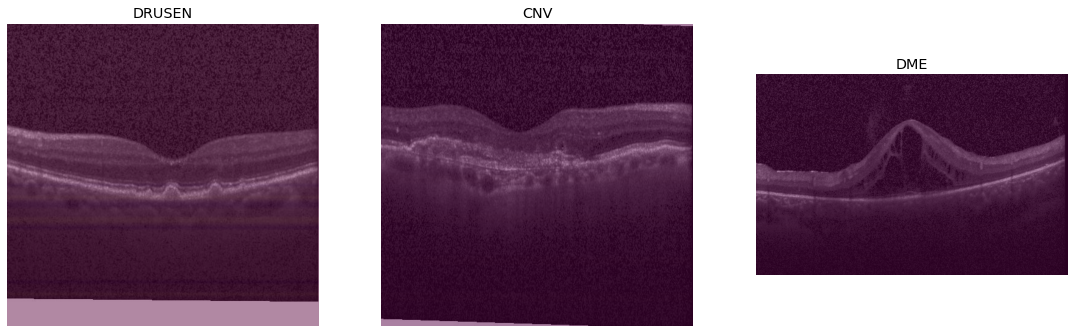

In [105]:
plt.figure(figsize=(19,14))

plt.subplot(1,3,1)
plt.imshow(overlap_drusen[1])
plt.axis('off')
plt.title('DRUSEN')

plt.subplot(1,3,2)
plt.imshow(overlap_cnv[1])
plt.axis('off')
plt.title('CNV')

plt.subplot(1,3,3)
plt.imshow(overlap_dme[1])
plt.axis('off')
plt.title('DME')

plt.show()

## 3.8 Xception

In [106]:
pred_7_drusen = model_7.predict(drusen_tensor)
i_7_drusen = np.argmax(pred_7_drusen)
print('DRUSEN class image predicted as class {} image with confidence equal to {}'.format(i_7_drusen, round(pred_7_drusen[0][i_7_drusen], 2)))

pred_7_cnv = model_7.predict(cnv_tensor)
i_7_cnv = np.argmax(pred_7_cnv)
print('CNV class image predicted as class {} image with confidence equal to {}'.format(i_7_cnv, round(pred_7_cnv[0][i_7_cnv], 2)))
      
pred_7_dme = model_7.predict(dme_tensor)
i_7_dme = np.argmax(pred_7_dme)
print('DME class image predicted as class {} image with confidence equal to {}'.format(i_7_dme, round(pred_7_dme[0][i_7_dme], 2)))

DRUSEN class image predicted as class 2 image with confidence equal to 1.0
CNV class image predicted as class 0 image with confidence equal to 1.0
DME class image predicted as class 1 image with confidence equal to 1.0


In [107]:
icam_drusen = GradCAM(model_7, i_7_drusen)
heatmap = icam_drusen.compute_heatmap(drusen_tensor)
heatmap = cv2.resize(heatmap, (drusen_W, drusen_H))
overlap_drusen = icam_drusen.overlay_heatmap(heatmap, drusen, alpha=0.5)
overlap_drusen = np.asarray(overlap_drusen)

icam_cnv = GradCAM(model_7, i_7_cnv)
heatmap = icam_cnv.compute_heatmap(cnv_tensor)
heatmap = cv2.resize(heatmap, (cnv_W, cnv_H))
overlap_cnv = icam_drusen.overlay_heatmap(heatmap, cnv, alpha=0.5)
overlap_cnv = np.asarray(overlap_cnv)

icam_dme = GradCAM(model_7, i_7_dme)
heatmap = icam_dme.compute_heatmap(dme_tensor)
heatmap = cv2.resize(heatmap, (dme_W, dme_H))
overlap_dme = icam_dme.overlay_heatmap(heatmap, dme, alpha=0.5)
overlap_dme = np.asarray(overlap_dme)

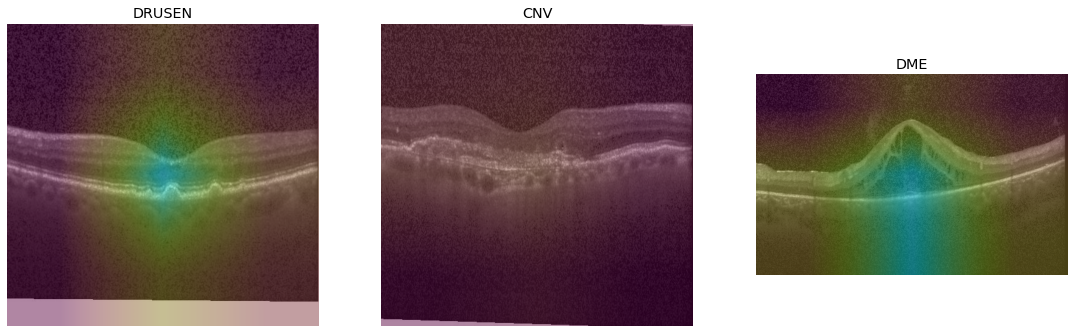

In [108]:
plt.figure(figsize=(19,14))

plt.subplot(1,3,1)
plt.imshow(overlap_drusen[1])
plt.axis('off')
plt.title('DRUSEN')

plt.subplot(1,3,2)
plt.imshow(overlap_cnv[1])
plt.axis('off')
plt.title('CNV')

plt.subplot(1,3,3)
plt.imshow(overlap_dme[1])
plt.axis('off')
plt.title('DME')

plt.show()

# 4. Conclusion

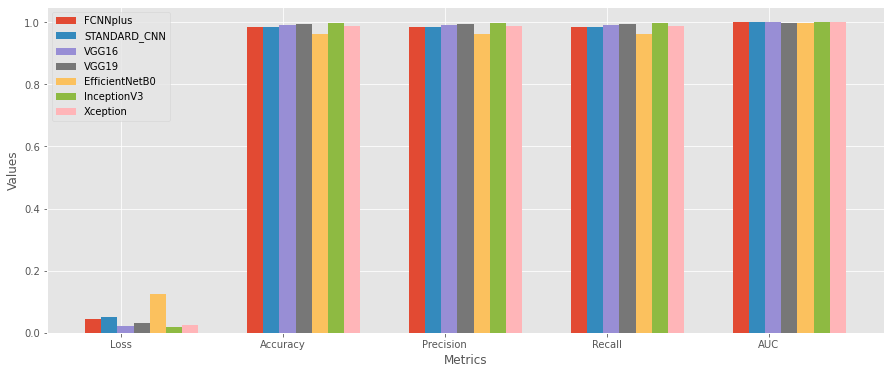

In [111]:
metrics_label = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
w = .1

bar1 = np.arange(len(metrics_label))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]
bar6 = [i+w for i in bar5]
bar7 = [i+w for i in bar6]

plt.figure(figsize=(15,6))

plt.bar(bar1, test_results_1, w, label='FCNNplus')
plt.bar(bar2, test_results_2, w, label='STANDARD_CNN')
plt.bar(bar3, test_results_3, w, label='VGG16')
plt.bar(bar4, test_results_4, w, label='VGG19')
plt.bar(bar5, test_results_5, w, label='EfficientNetB0')
plt.bar(bar6, test_results_6, w, label='InceptionV3')
plt.bar(bar7, test_results_7, w, label='Xception')

plt.xticks(bar1+12*w/7, metrics_label)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()

plt.show()

From the experiments carried out and the comparison of the results obtained from the various models, it is clear that a model based on CNNs can be of great help during the diagnosis phase of the disease, particularly as a tool to automate the process.  
All networks achieve above-average quantitative performance, but looking at the heatmaps produced by the GradCAM algorithm shows that only models based on the FCNNplus and STANDARD_CNN architectures succeed in identifying the correct clinical patterns.